In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import ta
import logging
from typing import Tuple
import warnings
warnings.filterwarnings("ignore")
# Setting up basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [7]:
class CryptoDataFetcher:
    def __init__(self, coin: str):
        self.coin = coin
        self.base_url = "https://api.binance.com/api/v3/klines"
        self.interval = "1m"
        self.limit = 1000

    def _fetch_data(self, start_timestamp: int, end_timestamp: int) -> pd.DataFrame:
        klines = []
        current_start_timestamp = start_timestamp
        current_end_timestamp = start_timestamp + self.limit * 60000

        while current_start_timestamp < end_timestamp:
            if current_end_timestamp > end_timestamp:
                current_end_timestamp = end_timestamp

            url = f"{self.base_url}?symbol={self.coin}&interval={self.interval}&startTime={current_start_timestamp}&limit={self.limit}"
            response = requests.get(url)

            if response.status_code == 200:
                data = response.json()
                for kline in data:
                    klines.append([kline[0], kline[4]])  # Open time and Close price
                current_start_timestamp = current_end_timestamp
                current_end_timestamp += self.limit * 60000
            else:
                logging.error("Failed to retrieve data from Binance API")
                break

        df = pd.DataFrame(klines, columns=["Date", "Close"])
        df["Date"] = pd.to_datetime(df["Date"], unit='ms')
        return df

    def get_data(self) -> pd.DataFrame:
        try:
            prev_file = pd.read_hdf(f'Data/{self.coin}.h5', key='my_data')
            prev_file=prev_file[["Date", "Close"]]
            logging.info("Access to old file is granted")
        except FileNotFoundError:
            logging.info("Previous file not found, creating new.")
            prev_file = pd.DataFrame(columns=["Date", "Close"])

        if not prev_file.empty:
            last_date = pd.to_datetime(prev_file["Date"].iloc[-1])
            start_timestamp = int(last_date.timestamp()) * 1000
        else:
            start_timestamp = int((datetime.now() - timedelta(days=1)).timestamp()) * 1000

        end_timestamp = int(datetime.now().timestamp()) * 1000

        new_data = self._fetch_data(start_timestamp, end_timestamp)
        final_data = pd.concat([prev_file, new_data]).drop_duplicates(subset='Date', keep='first')
        final_data.to_csv(f'{self.coin}.csv', index=False)
        final_data.to_hdf(f'Data/{self.coin}.h5', key='my_data', mode='w')

        return final_data
    


In [11]:
class PairTradingStrategy:
    def __init__(self, merged_data: pd.DataFrame, z_score_threshold: float, window1: int, window2: int,look_back:int,rsi_up:float,rsi_down:float):
        self.merged_data = merged_data
        self.z_score_threshold = z_score_threshold
        self.window1 = window1
        self.window2 = window2
        self.look_back=look_back
        self.rsi_up=rsi_up
        self.rsi_down=rsi_down
        self.pnl_data = []

    def execute_strategy(self) -> float:

        btc = self.merged_data['BTC'].astype(float)
        eth = self.merged_data['ETH'].astype(float)
        ratios = btc / eth
        ma1 = ratios.rolling(window=self.window1).mean()
        ma2 = ratios.rolling(window=self.window2).mean()
        std = ratios.rolling(window=self.window1).std()
        zscore = (ratios - ma2) / std
        rsi = ta.momentum.RSIIndicator(ratios, window=self.window2).rsi()
        money = 0
        count_btc = count_eth = 0
        position = 0
        transaction_cost = 0.0005  # 0.05%
        cost = 0
        ewma_std = ratios.ewm(span=self.window2).std()
        MtM=0
        position_i=0
        for i in range(len(ratios)):
            dynamic_threshold = (self.z_score_threshold + (ewma_std[i]))
            if zscore[i] < dynamic_threshold and zscore[i-self.look_back:i].max() > dynamic_threshold and position == 0 and rsi[i]>self.rsi_up:
                cost = (btc[i] + (eth[i] * ratios[i])) * transaction_cost
                if (count_btc) >= 0 and (count_eth) <= 0:
                    money += btc[i] - eth[i] * ratios[i]-cost
                    count_btc -= 1
                    count_eth += ratios[i]
                    position = -1
                    position_i=i
                    MtM=0
            elif zscore[i] > -dynamic_threshold+0.2 and zscore[i-self.look_back:i].min() < -dynamic_threshold  and position == 0  and rsi[i]<self.rsi_down:
                cost = (btc[i] + (eth[i] * ratios[i])) * transaction_cost
                if (count_btc) <= 0 and (count_eth) <= 0:
                    money += btc[i] - eth[i] * ratios[i]-cost
                    count_btc += 1
                    count_eth -= ratios[i]
                    position = 1
                    position_i=i
                    MtM=0

            elif (zscore[i]) < dynamic_threshold*0.5 and zscore[i-self.look_back:i].max() > dynamic_threshold*0.5 and position == 1:
                cost = (btc[i] + (eth[i] * ratios[i])) * transaction_cost
                money += btc[i] * count_btc + eth[i] * count_eth-cost
                count_btc = 0
                count_eth = 0
                position = 0
                MtM = 0
            elif (zscore[i]) > -dynamic_threshold*0.5 and (zscore[i])+0.2 < dynamic_threshold*0.5 and zscore[i-self.look_back:i].min() < -dynamic_threshold*0.5 and position == -1:
                cost = (btc[i] + (eth[i] * ratios[i])) * transaction_cost
                money += btc[i] * count_btc + eth[i] * count_eth-cost
                count_btc = 0
                count_eth = 0
                position = 0
                MtM = 0
            else:
                if position==1:
                    MtM = (btc[i]*1 - eth[i] * ratios[position_i])
                elif position==-1:
                    MtM = (-btc[i]*1 + eth[i] * ratios[position_i])
                else:
                    MtM=0
                

            self.pnl_data.append(
                [ratios.index[i], money,MtM, count_btc, count_eth,ma1.iloc[i],ma2.iloc[i],ratios.iloc[i], self.merged_data['BTC'].iloc[i], self.merged_data['ETH'].iloc[i], position,
                 zscore.iloc[i],dynamic_threshold, rsi.iloc[i]]
            )

        return money
    def visualize_strategy(self):
        PnL_df = pd.DataFrame(self.pnl_data,
                              columns=['Date', 'PnL', 'MtM', '#BTC', '#ETH','MA1','MA2','Ratio', 'Price BTC', 'Price ETH', 'Position',
                                       'z_score','Dynamic_Zscore', 'rsi'])
        # Identify trade signals for plotting
        PnL_df['TradeType'] = np.where((PnL_df['Position'] == 1) & (PnL_df['Position'].shift(1) == 0), 'Go Long',
                                       np.where((PnL_df['Position'] == -1) & (PnL_df['Position'].shift(1) == 0),
                                                'Go Short',
                                                np.where(
                                                    (PnL_df['Position'] == 0) & (abs(PnL_df['Position'].shift(1)) == 1),
                                                    'Exit Position', 'No Action')))
        PnL_df['Date']=pd.to_datetime(PnL_df['Date'])
        PnL_df=PnL_df.set_index("Date")

        fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

        axes[0].plot(PnL_df['Ratio'], label='Ratio')
        axes[0].axhline(PnL_df['Ratio'].mean(), color='black')
        axes[0].plot(PnL_df['MA1'], label="EMA1")
        axes[0].plot(PnL_df['MA2'], label="EMA2")
        axes[0].legend(loc='upper left')
        axes[0].set_title('BTC and ETH Pair Ratio')

        # Plot 2: Z-Score
        axes[1].plot(PnL_df['z_score'], label='Z-Score', color='orange')
        axes[1].plot(PnL_df['Dynamic_Zscore'], color='r', linestyle='--', label='Upper Threshold')
        axes[1].plot(-PnL_df['Dynamic_Zscore'], linestyle='--', label='Lower Threshold')
        axes[1].plot(PnL_df['Dynamic_Zscore']*0.5, color='g',  linestyle='--', label='Mid Threshold')
        axes[1].plot(-PnL_df['Dynamic_Zscore']*0.5, color='g',  linestyle='--', label='Mid Threshold')
        axes[1].plot(PnL_df['Position'], color='grey',  linestyle='--', label='Position')

        # axes[1].axhline(y=1, color='r', linestyle='--', label='Upper Threshold')
        # axes[1].axhline(y=-1, color='r', linestyle='--', label='Lower Threshold')
        # axes[1].axhline(y=0.5, color='g', linestyle='--', label='Mid Threshold')
        # axes[1].axhline(y=-0.5, color='g', linestyle='--', label='Mid Threshold')
        axes[1].legend(loc='upper left')
        axes[1].set_title('Z-Score')

        Long = PnL_df[PnL_df['TradeType'] == 'Go Long']
        Short = PnL_df[PnL_df['TradeType'] == 'Go Short']
        Exit = PnL_df[PnL_df['TradeType'] == 'Exit Position']

        axes[2].plot(Long['PnL'], marker='^', color='green', linestyle='', markersize=10,
                     label='Long Signal')
        axes[2].plot(Short['PnL'], marker='^', color='orange', linestyle='', markersize=10,
                     label='Short Signal')
        axes[2].plot(Exit['PnL'], marker='v', color='red', linestyle='', markersize=10,
                     label='Exit Signal')

        axes[2].plot(PnL_df['PnL'], label='PnL', color='purple')
        axes[2].plot(PnL_df['MtM'], label='MtM', color='red')
        axes[2].legend(loc='upper left')
        axes[2].set_title('PnL of strategy')

        axes[3].plot(PnL_df['rsi'], label='RSI', color='orange')
        axes[3].axhline(y=50, color='r', linestyle='--')
        axes[3].legend(loc='upper left')
        axes[3].set_title('RSI')
        # Display the plots
        # plt.tight_layout()
        # plt.savefig('BTC_ETH.png')
        plt.show()
        PnL_df.to_excel("log.xlsx")

2024-05-12 14:21:52,545 - INFO - Access to old file is granted
2024-05-12 14:22:00,301 - INFO - Access to old file is granted


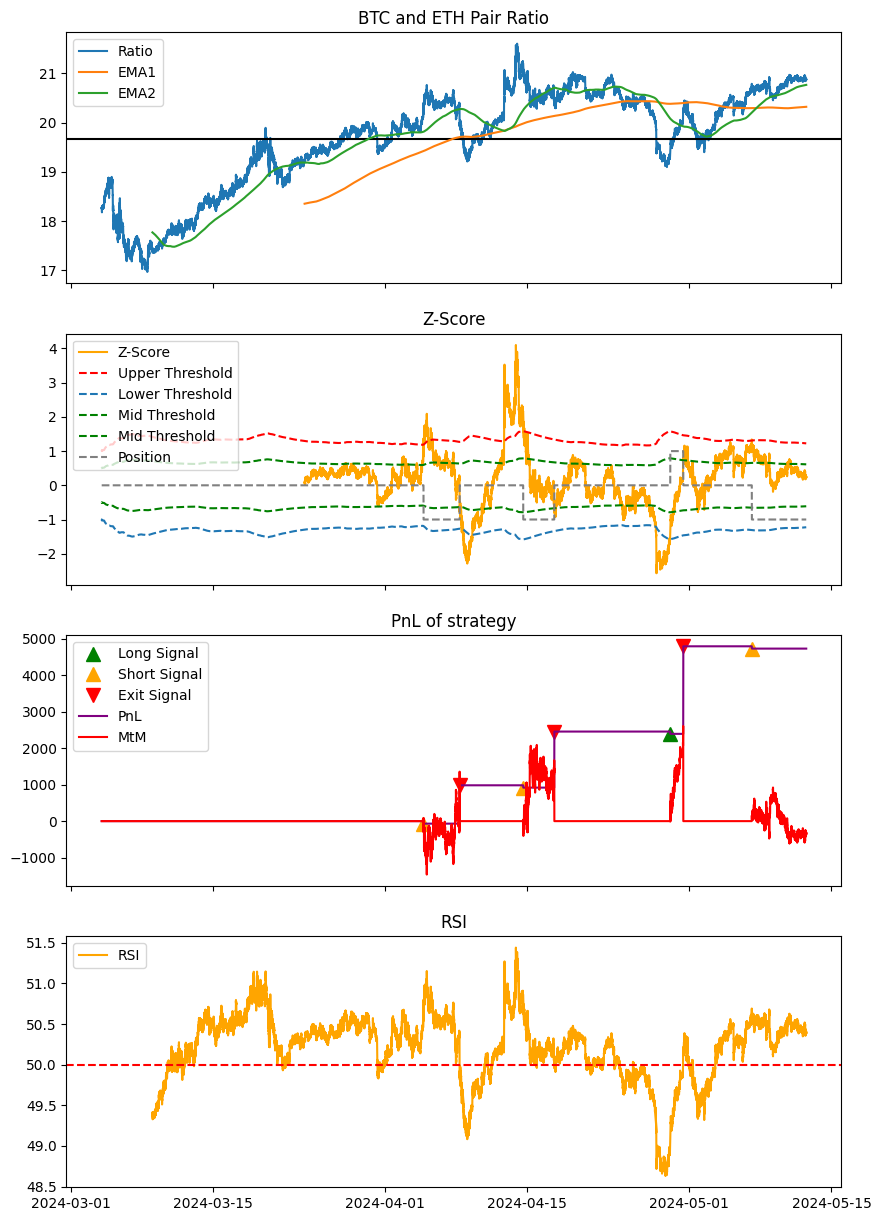

In [12]:

if __name__ == "__main__":
    btc_fetcher = CryptoDataFetcher('BTCUSDT')
    eth_fetcher = CryptoDataFetcher('ETHUSDT')

    btc_data = btc_fetcher.get_data()
    eth_data = eth_fetcher.get_data()
    btc_data['Date'] = pd.to_datetime(btc_data['Date'])
    eth_data['Date'] = pd.to_datetime(eth_data['Date'])
    btc_data = btc_data.rename(columns={'Open time': 'Date', 'Close': 'BTC'})
    eth_data = eth_data.rename(columns={'Open time': 'Date', 'Close': 'ETH'})
    merged_data=pd.merge(btc_data,eth_data,on='Date',how='left').dropna()
    merged_data=merged_data.set_index('Date')
    strategy = PairTradingStrategy(merged_data[-100000:], 1, 28800, 7200,60*12,50.5,49.5)
    strategy.execute_strategy()
    strategy.visualize_strategy()